<div style="text-align: center;">
    <img src="../Streamlit/project_toto_logo.png" width="300" height="300">
</div>

# Project TOTO: Tornado Outbreak Threat Observations
ML Model: Developed by Michael Goodman

## Problem

Iowa is known for experiencing a high number of tornado events each year. These tornadoes can cause significant damage to property and pose a threat to the safety of residents. Therefore, accurately predicting tornado events in Iowa is crucial for effective disaster preparedness and response.

While advancements in meteorological technology have improved the accuracy of tornado warnings, there are still challenges in achieving a high level of precision. One of the main challenges is the occurrence of false positives, where a tornado warning is issued but no tornado actually forms. False positives can lead to unnecessary panic and disruptions in daily life, potentially causing complacency among residents when real tornado threats arise.

The goal of this project is to develop a predictive model that can effectively identify and forecast tornado events in Iowa. By leveraging historical weather data, atmospheric conditions, and other relevant factors, we aim to improve the accuracy of tornado predictions and minimize false positives. This will enable authorities to issue timely and accurate warnings, allowing residents to take appropriate safety measures and mitigate the potential impact of tornado events.

Through this project, we hope to contribute to the ongoing efforts in enhancing tornado prediction capabilities, ultimately improving the safety and resilience of Iowa communities in the face of severe weather events.

## Assumption

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="supercell.png" alt="Supercells are assumed primary indicator" style="max-width: 100%;">
        <p> </p>
    </div>
    <br>
    <div style="flex: 1; text-align: center;margin-left: 20px;">
        <img src="updraft.png" alt="Warm temperature can rotate a supercell" style="max-width: 100%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://scijinks.gov/tornado" target="_blank">NOAA SciJinks</a></p>
</center>


- The above diagrams explain the fundemental components of a tornado formation based on scientific studies. We will attempt to use a combination of these metrics to assign a tornado formation risk
- As Iowa is mostly topagraphically consistent, the initial risk is constant across the state. This would not be the case in larger states like Illinois or Texas. 
- Wind Shear is often not a metric included in weather APIs, we will calculate our own measure by understanding the difference in magnitude of wind vectors at different altitudes. 

- From the studies, the largest risk factor associated with tornados is not the weather itself, but the change and variation in weather. We will attempt to measure this by having various rolling average signals as independent variables


## Data Engineering

#### Location Data

Location parameters were set as the centroid of Iowa Counties. Calculated using GeoPandas on an Iowa County Shape File obtained here: 
- https://geodata.iowa.gov/datasets/iowa::iowa-county-boundaries/about



Total counties: 99


C:\Users\goodm\AppData\Local\Temp\ipykernel_36544\3627250833.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
C:\Users\goodm\AppData\Local\Temp\ipykernel_36544\3627250833.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.centroid.y
C:\Users\goodm\AppData\Local\Temp\ipykernel_36544\3627250833.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf.centroid.x


Centroid data saved to Iowa_Counties_Centroid.csv


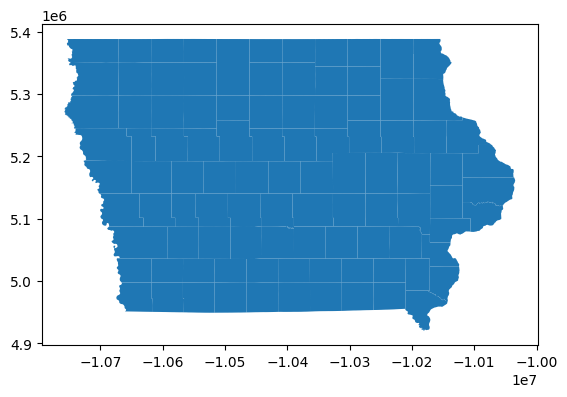

In [15]:
import geopandas as gpd

# Define the file path
shapefile_path = 'Iowa_County_Boundaries\IowaCounties.shp'

# Try reading the shapefile
try:
    gdf = gpd.read_file(shapefile_path)
    print("Total counties:", len(gdf))
    gdf.plot()
except FileNotFoundError:
    print(f"Shapefile not found at {shapefile_path}")
    exit()

# Check and convert CRS if necessary
if gdf.crs != 'epsg:4326':
    gdf = gdf.to_crs('epsg:4326')

# Calculate centroids
gdf['centroid'] = gdf.geometry.centroid
gdf['latitude'] = gdf.centroid.y
gdf['longitude'] = gdf.centroid.x

# Select relevant columns
centroid_data = gdf[['CountyName', 'latitude', 'longitude']]

# Define the output file path
output_csv_path = 'Iowa_Counties_Centroid.csv'

# Save to CSV
centroid_data.to_csv(output_csv_path, index=False)
print(f"Centroid data saved to {output_csv_path}")


Data Model sources were obtained from two sources: 
- Iowa Weather Sensor History: 
    
    https://open-meteo.com/en/docs/historical-weather-api#location_mode=csv_coordinates 

    This is a free API that allows us to request sensor information going back 6 years (5 years of training, 1 year of test).
    To avoid API throttle limits, the GUI was used with the centroid file as our list of locations

    Data Saved at: **historical_weather_ia.csv**, due to size this is in gitignore <br><br>

    
- NOAA: National Oceanic and Atmospheric Administration

    https://www.ncdc.noaa.gov/stormevents/choosedates.jsp?statefips=19%2CIOWA#

    Storm Events database to request CSV of Tornado events in Iowa, their severity, and location from 1/1/2018 through 12/31/2023


    Data Saved at: **TornadoEvents.csv**, due to size this is in gitignore



### Data Cleaning and Joining

- Event_ID needed to be created to join Tornado events and historical data
    - County-Date-Time
    - Various cleaning and standardization needed to join
    - Tornado Binary event determined if tornado happened within +-3 hours of weather record

In [16]:
import pandas as pd
import numpy as np

# Load weather data
weather_df = pd.read_csv('historical_weather_IA.csv')

# Load county centroid data and map county names to weather data
df_counties = pd.read_csv('Iowa_Counties_Centroid.csv')
weather_df['county_name'] = weather_df['location_id'].apply(lambda x: df_counties.loc[x, 'CountyName'])
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Load tornado data
df_tornado = pd.read_csv('TornadoEvents.csv')
df_tornado['CZ_NAME_STR'] = df_tornado['CZ_NAME_STR'].apply(lambda x: x.title().replace(' Co.', ''))
df_tornado['BEGIN_DATETIME'] = pd.to_datetime(df_tornado['BEGIN_DATE'] + ' ' + df_tornado['BEGIN_TIME'].apply(lambda x: str(x).zfill(4)[:2] + ':' + str(x).zfill(4)[2:]))

# Initialize the tornado column to 0
weather_df['tornado'] = 0

# Iterate over tornado events and update the tornado binary within a 3-hour window and 1 hour after
for idx, tornado_event in df_tornado.iterrows():
    tornado_time = tornado_event['BEGIN_DATETIME']
    county = tornado_event['CZ_NAME_STR']
    
    time_window_start = tornado_time - pd.Timedelta(hours=3)
    time_window_end = tornado_time + pd.Timedelta(hours=1)
    
    mask = (
        (weather_df['county_name'] == county) &
        (weather_df['time'] >= time_window_start) &
        (weather_df['time'] <= time_window_end)
    )
    
    weather_df.loc[mask, 'tornado'] = 1

In [19]:
# Set display options for viewing
pd.set_option('display.max_columns', 500)
weather_df.head()

,location_id,time,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,county_name,tornado
0,0,2018-01-01 00:00:00,-21.2,72,0.0,1050.5,989.6,8.1,18.0,298,305,19.1,Lyon,0
1,0,2018-01-01 01:00:00,-20.7,72,0.0,1050.7,989.9,8.1,17.8,304,310,18.9,Lyon,0
2,0,2018-01-01 02:00:00,-20.2,71,0.0,1050.5,989.8,7.5,17.2,307,314,18.8,Lyon,0
3,0,2018-01-01 03:00:00,-20.0,71,0.0,1050.6,989.9,6.9,16.3,303,314,18.6,Lyon,0
4,0,2018-01-01 04:00:00,-20.2,70,0.0,1050.8,990.1,6.3,15.5,297,311,18.5,Lyon,0


In [17]:
#export weather_df as parquet file
weather_df.to_parquet('weather_events.parquet')

### EDA

In [1]:
#read in parquet file if not already read in
import pandas as pd
weather_df = pd.read_parquet('weather_events.parquet')

In [21]:
weather_df['tornado'].value_counts()

tornado
0    5204680
1       1136
Name: count, dtype: int64

In [20]:
#ratio of tornado events to non-tornado events
print(weather_df['tornado'].mean()*100, '% of the data is tornado events')

#weight for ML model
weight = 1 / weather_df['tornado'].mean()
print('Weight for ML model:', weight.round(2))


0.021821747061363674 % of the data is tornado events
Weight for ML model: 4582.58


70.56728247914184


<Axes: ylabel='Frequency'>

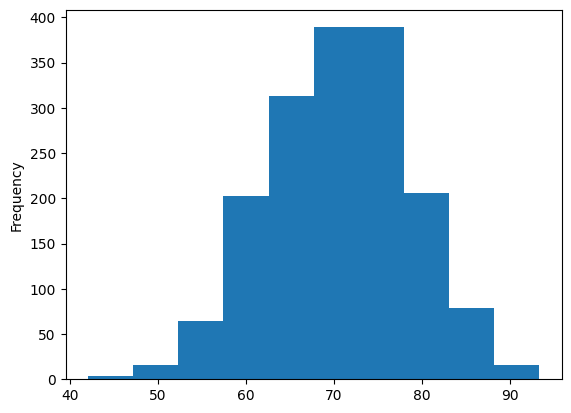

In [14]:
#show me average temperature when tornado is 1
print(weather_df[weather_df['tornado'] == 1]['temperature_2m'].mean())
#make plot of temperature when tornado is 1
weather_df[weather_df['tornado'] == 1]['temperature_2m'].plot.hist()

<Axes: ylabel='Frequency'>

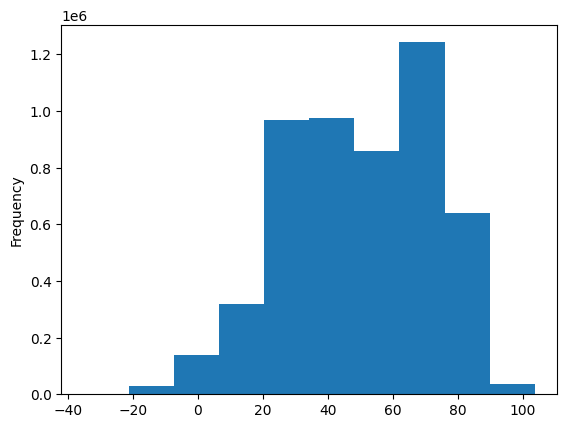

In [10]:
#plot of temperature when tornado is 0
weather_df[weather_df['tornado'] == 0]['temperature_2m'].plot.hist()

In [14]:
#pressure when tornado is 1
print(weather_df[weather_df['tornado'] == 1]['pressure_msl'].mean())

1004.0031690140846


In [15]:
#pressure when tornado is 0
print(weather_df[weather_df['tornado'] == 0]['pressure_msl'].mean())

1016.9329852747921


<Axes: ylabel='Frequency'>

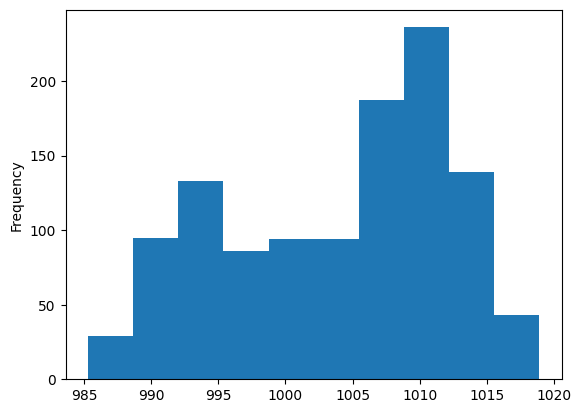

In [16]:
#histogram of pressure when tornado is 1
weather_df[weather_df['tornado'] == 1]['pressure_msl'].plot.hist()

<Axes: ylabel='Frequency'>

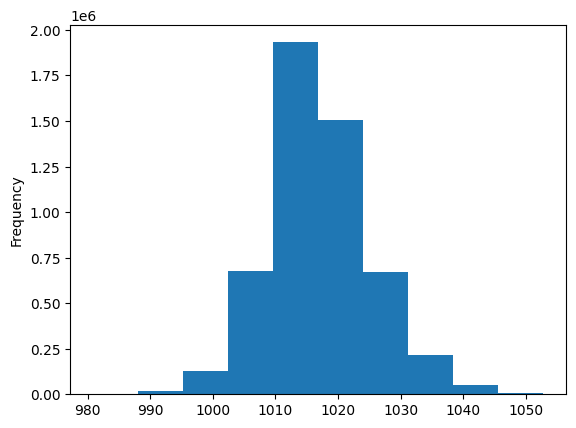

In [18]:
#hist of pressure
weather_df['pressure_msl'].plot.hist()

In [7]:
weather_df.head()

,location_id,time,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,county_name,tornado
0,0,2018-01-01 00:00:00,-21.2,72,0.0,1050.5,989.6,8.1,18.0,298,305,19.1,Lyon,0
1,0,2018-01-01 01:00:00,-20.7,72,0.0,1050.7,989.9,8.1,17.8,304,310,18.9,Lyon,0
2,0,2018-01-01 02:00:00,-20.2,71,0.0,1050.5,989.8,7.5,17.2,307,314,18.8,Lyon,0
3,0,2018-01-01 03:00:00,-20.0,71,0.0,1050.6,989.9,6.9,16.3,303,314,18.6,Lyon,0
4,0,2018-01-01 04:00:00,-20.2,70,0.0,1050.8,990.1,6.3,15.5,297,311,18.5,Lyon,0


### Feature Engineering

As mentioned above, a tornado is formed when thunderstorms mix with wind shear creating a supercell. As the warm front mixes with the cool air it can rotate the supercell and when it touches the ground it forms a tornado. 

The weather sensor data alone does not provide enough information to predict tornado as the differences in wind speed and direction are not captured in the data table without additional calculations  

We decided to measure the magnitude of the wind shear with vector calculations and applied signals to the data to determine the change in temperature, rain, and pressure. Many of which are factors that create a thunderstorm

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="shear_calc.png" alt="" style="max-width: 25%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://learningweather.psu.edu/node/93" target="_blank">Penn State Department of Meteorology</a></p>
</center>

In [19]:
import numpy as np
def calculate_wind_shear(speed1, speed2, dir1, dir2):
    # Convert wind directions from degrees to radians
    dir1_rad = np.radians(dir1)
    dir2_rad = np.radians(dir2)

    # Calculate the wind vector components at the first altitude
    u1 = speed1 * np.sin(dir1_rad)
    v1 = speed1 * np.cos(dir1_rad)

    # Calculate the wind vector components at the second altitude
    u2 = speed2 * np.sin(dir2_rad)
    v2 = speed2 * np.cos(dir2_rad)

    # Calculate the wind shear components
    shear_u = u2 - u1
    shear_v = v2 - v1

    # Calculate the magnitude of the wind shear vector
    shear_magnitude = np.sqrt(shear_u**2 + shear_v**2)
    
    return shear_magnitude

In [20]:
weather_df['wind_shear'] = weather_df.apply(lambda x: calculate_wind_shear(x['wind_speed_10m'], x['wind_speed_100m'], x['wind_direction_10m'], x['wind_direction_100m']), axis=1)

<Axes: ylabel='Frequency'>

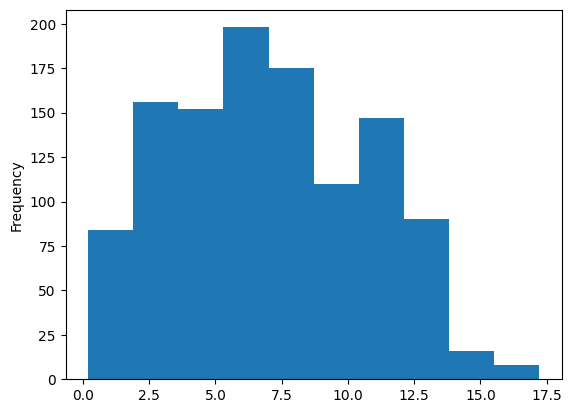

In [24]:
#histogram of wind shear when tornado is 1
weather_df[weather_df['tornado'] == 1]['wind_shear'].plot.hist()


<Axes: ylabel='Frequency'>

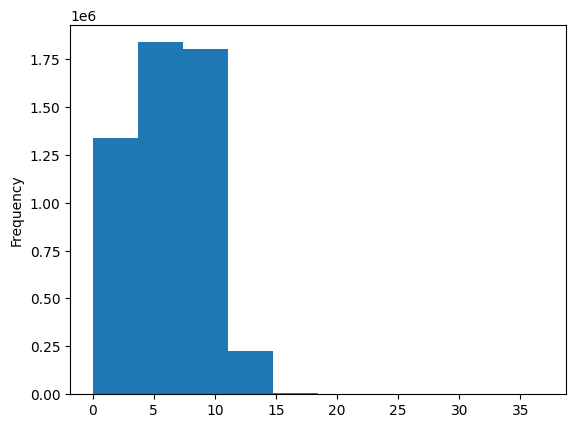

In [23]:

#histogram of wind shear when tornado is 0
weather_df[weather_df['tornado'] == 0]['wind_shear'].plot.hist()


In [ ]:
#signal processing with MA windows

## Model Approach

### Initial Model

#### Basic xgboost with classification weight

In [2]:
#import train test split, standard scaler, logistic regression, classification report, confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#logistic regression cv
from sklearn.linear_model import LogisticRegressionCV
#import accuracy score
from sklearn.metrics import accuracy_score


In [3]:
X = weather_df.drop(columns=['tornado', 'time','county_name'])
y = weather_df['tornado']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
#initial xgboost model
from xgboost import XGBClassifier
#use weight for imbalanced data
model = XGBClassifier(scale_pos_weight=weight)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#confusion matrix
confusion_matrix(y_test, y_pred)

Accuracy: 99.48%


array([[1035607,    5317],
       [     83,     157]], dtype=int64)

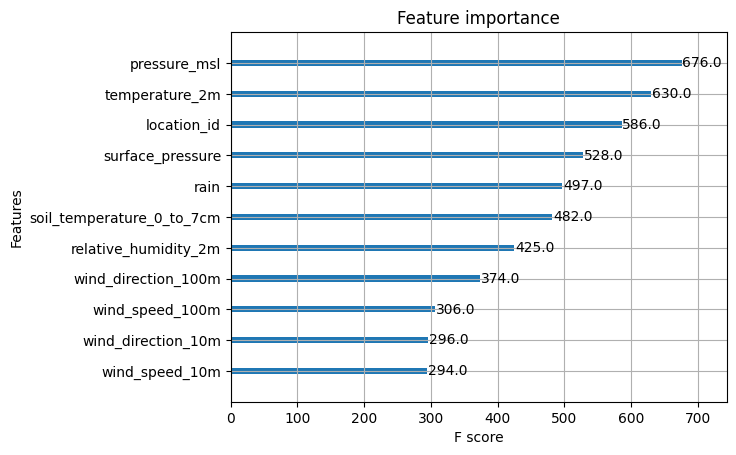

In [24]:
#feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()

In [25]:
#xgboost with l1 regularization
model = XGBClassifier(scale_pos_weight=weight, reg_alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#confusion matrix
confusion_matrix(y_test, y_pred)


Accuracy: 99.49%


array([[1035647,    5277],
       [     82,     158]], dtype=int64)

#### Neural Network Attempt

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

# Ensure the dataset is split into training and testing sets
# Assuming X_train, X_test, y_train, y_test are already defined

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Load the best model
model = load_model('best_model.keras')

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/100
104109/104117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9935 - loss: 0.0193
Epoch 1: val_loss improved from inf to 0.00197, saving model to best_model.keras
104117/104117 ━━━━━━━━━━━━━━━━━━━━ 175s 2ms/step - accuracy: 0.9935 - loss: 0.0193 - val_accuracy: 0.9998 - val_loss: 0.0020
Epoch 2/100
104099/104117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0020
Epoch 2: val_loss improved from 0.00197 to 0.00178, saving model to best_model.keras
104117/104117 ━━━━━━━━━━━━━━━━━━━━ 184s 2ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9998 - val_loss: 0.0018
Epoch 3/100
104112/104117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0018
Epoch 3: val_loss improved from 0.00178 to 0.00177, saving model to best_model.keras
104117/104117 ━━━━━━━━━━━━━━━━━━━━ 177s 2ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9998 - val_loss: 0.0018
Epoch 4/100
104087/104117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0018
Ep

KeyboardInterrupt: 

In [7]:
model = load_model('best_model.keras')

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

32537/32537 ━━━━━━━━━━━━━━━━━━━━ 21s 647us/step
Accuracy: 99.98%
Confusion Matrix:
[[1040924       0]
 [    240       0]]


### Parameter Tuning

### Model Selection

#### Justification

## Results and Insights

### Future Considerations

- Spatial and Time component, use LSTM
- Neural Network adjusting weights depending on results of others
- Transformers are faster now, could be used even when necesity requires as close to real time as possible

# Model Output

In [1]:
#export model as pickle file